# AB test experiments

Проведем ряд экспериментов для более глубокого понимания принципов проведения АБ-тестирования и применяемых для этого статистических методов

## Полезные ссылки

#### В работе использованы следующие материалы
Ссылка | Краткое описание | Автор материала
--|--|--
[Воркшоп A/B testing](https://www.youtube.com/watch?v=O6FXzCFnJxM)| AB тестирование, основные этапы, проблемы, решения | Валерий Бабушкин
[AB testing](https://www.youtube.com/watch?v=dFCJysbOJ8c)| A/B-тестирование: как сделать так, чтобы оно заработало | Анатолий Карпов
[AB testing](https://www.youtube.com/watch?v=jnFVmtaeSA0)| Тонкости A/B тестирования: проблема подглядывания | Анатолий Карпов
[AB test sample size](https://www.youtube.com/watch?v=2nP_gcut7SU)| Как и зачем оценивать размер выборки для A/B теста? | Анатолий Карпов
[AB test sample size](https://www.youtube.com/watch?v=JEAsoUrX6KQ) | How to Estimate Sample Size in A/B Tests | Data Interview Pro, Emma
[AB test sample size](https://jeffshow.com/caculate-abtest-required-sample-size.html)| Compare calculating methods | Jeff Show
[Evan’s Awesome A/B Tools](https://www.evanmiller.org/ab-testing/) | Intuitive statistical calculators, ideal for planning and analyzing A/B tests | Evan Miller
[CUPED](https://bytepawn.com/reducing-variance-in-conversion-ab-testing-with-cuped.html#reducing-variance-in-conversion-ab-testing-with-cuped) | Reducing variance in conversion A/B testing with CUPED | Marton Trencseni

Огромное спасибо авторам за проделанную работу!

## Распределение p-value для выборок из одной генеральной совокупности 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
from matplotlib.pyplot import plot
import seaborn as sns

Сгенерируем две выборки с нормальным распределением с одинаковыми параметрами (среднее 10, стандартное отклонение 1, размер выборки 1000), т.е. выборки принадлежат одной генеральной совокупности

In [2]:
r_1 = np.random.normal(100, 10, 1000)
r_2 = np.random.normal(100, 10, 1000)

Построим гистограммы полученных распределений

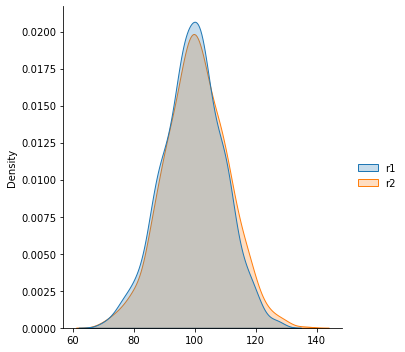

In [3]:
sns.displot(pd.DataFrame(r_1, columns=['r1']).join(pd.DataFrame(r_2, columns=['r2'])), kind='kde', fill=True)

In [4]:
result = ttest_ind(r_1, r_2)
result

Ttest_indResult(statistic=-2.4248870867512378, pvalue=0.015401287608947491)

Что же такое `p-value`: Если мы не отвергаем H0 (т.е. считаем что обе выборки принадлежат одной генеральной совокупности), то с вероятностью `p-value` мы бы могли получить такие выборки или еще более отличающиеся.
P-value обычно сравнивают со значением статистической значимости = 0.05 (5%) или 0.01 (1%).

Пусть в качестве границы выбрали 0.05  
Тогда:  
Если **p-value>0.05**, то нулевую  гипотезу **не отвергаем**. Нулевая гипотеза говорит о том что выборки принадлежат одной генеральной совокупности и разница между ними не статистически значима.  
Если **p-value<0.05**, то нулевую  гипотезу **отвергаем**. Соответственно считаем что выборки не принадлежат одной генеральной совокупности (более корректный тезис - считаем что не подтвердилась гипотеза о принадлежности выборок одной генеральной совокупности).

Интересный факт - если рассчитывать p-value для случайных выборок из одной генеральной совокупности, то получим равномерное распределение. Давайте его подтвердим.

In [5]:
%%time
p_val_list = []
for i in tqdm(range(100000)):
    norm_1 = np.random.normal(100, 10, 10000)
    norm_2 = np.random.normal(100, 10, 10000)
    result = ttest_ind(norm_1, norm_2)
    p_val_list.append(result[1])   

  0%|          | 0/100000 [00:00<?, ?it/s]

Wall time: 1min 13s


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

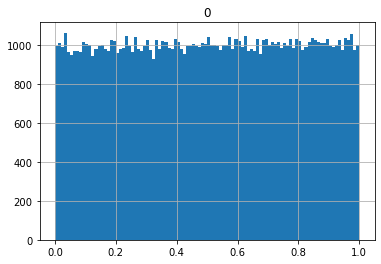

In [6]:
#sns.displot(pd.DataFrame(p_val_list), kind='kde', fill=True)
pd.DataFrame(p_val_list).hist(bins=100)

**Мы видим равномерное распределение!!!**

**Таким образом, при любом выборе уровня статистической значимости мы можем ошибиться.**  
Например, при уровне статистической значимости 0.05 мы получили p-value 0.04999 и отвергли нулевую гипотезу (т.е. считаем что гипотеза о принадлежности выборок одной генеральной совокупности не верна).    
**Вспоминаем о том, что получили равномерное распределение для p-value выборок из одной генеральной совокупности => с вероятностью в 5% мы ошиблись - получили ложноположительный результат - ошибку 1-го рода (в 1 случае из 20 мы ошибочно отвергаем нулевую гипотезу, т.е. такие выборки могли бы быть получены из одной генеральной совокупности)**

## Распределение p-value для выборок из разных генеральных совокупностей 

В данном разделе рассмотрим выборки из разных генеральных совокупностей. Внесем небольшое изменение в среднее одной из выборок (1%)

In [7]:
r_1 = np.random.normal(101, 10, 1000)
r_2 = np.random.normal(100, 10, 1000)

Построим гистограммы полученных распределений

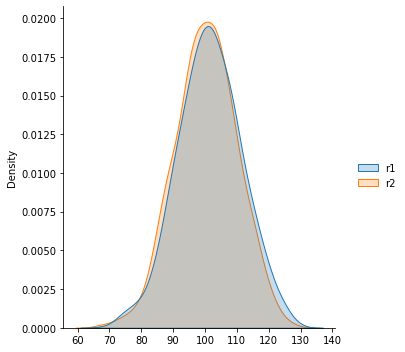

In [8]:
sns.displot(pd.DataFrame(r_1, columns=['r1']).join(pd.DataFrame(r_2, columns=['r2'])), kind='kde', fill=True)

Посмотрим распределение p-value.

In [9]:
%%time
p_val_list = []
for i in tqdm(range(100000)):
    norm_1 = np.random.normal(101, 10, 10000)
    norm_2 = np.random.normal(100, 10, 10000)
    result = ttest_ind(norm_1, norm_2)
    p_val_list.append(result[1])   

  0%|          | 0/100000 [00:00<?, ?it/s]

Wall time: 1min 11s


,0
count,1.000000e+05
mean,4.802305e-07
std,2.271441e-05
min,1.045985e-28
25%,9.825864e-15
50%,1.556583e-12
75%,1.674656e-10
max,5.391725e-03


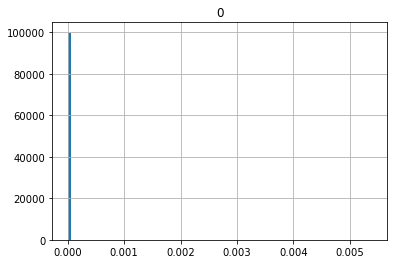

In [10]:
#sns.displot(pd.DataFrame(p_val_list), kind='kde', fill=True)
pd.DataFrame(p_val_list).hist(bins=100);
pd.DataFrame(p_val_list).describe()

**Среднее изменили всего на 1%, но как существенно поменялось распределение p-value. Для всех экспериментов p-value показыыает статистическую значимую разницу между выборками** (значение p-value примерно равно 0)

**А теперь при тех же значениях среднего, попробуем увеличить стандартное отклонение**

  0%|          | 0/100000 [00:00<?, ?it/s]

Wall time: 1min 12s


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

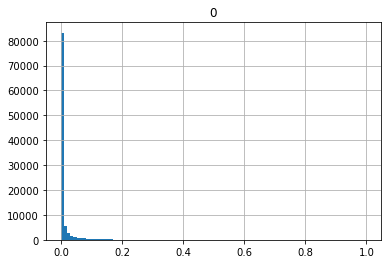

In [11]:
%%time
p_val_list = []
for i in tqdm(range(100000)):
    norm_1 = np.random.normal(101, 20, 10000)
    norm_2 = np.random.normal(100, 20, 10000)
    result = ttest_ind(norm_1, norm_2)
    p_val_list.append(result[1]) 
    
pd.DataFrame(p_val_list).hist(bins=100);

  0%|          | 0/100000 [00:00<?, ?it/s]

Wall time: 1min 13s


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

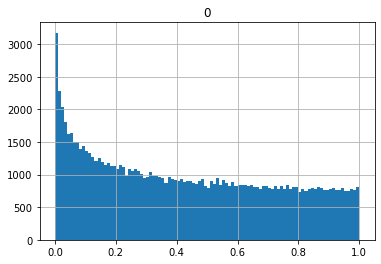

In [12]:
%%time
p_val_list = []
for i in tqdm(range(100000)):
    norm_1 = np.random.normal(101, 100, 10000)
    norm_2 = np.random.normal(100, 100, 10000)
    result = ttest_ind(norm_1, norm_2)
    p_val_list.append(result[1]) 
    
pd.DataFrame(p_val_list).hist(bins=100);

**Что же мы видим:** чем больше дисперсия, тем больше разброс наблюдается у p-value, тем сложнее нам "поймать" отличие выборок при проведении AB теста, тем выше вероятность ошибки.  
Соотвественно актуальной является задача снижения дисперсии контрольной и тестовой выборок при проведении AB тестов - в этом может помочь метод CUPID.

## CUPID для снижения дисперсии

в работе

## Продолжительность AB теста

в работе

## Основные этапы AB тестирования, проблемы и их решение

в работе (особенности выбора статистических критериев, преобразованое распределений, сплит на тест/контроль - ошибки, проверки, множественное сравнение при применение нескольких факторов)

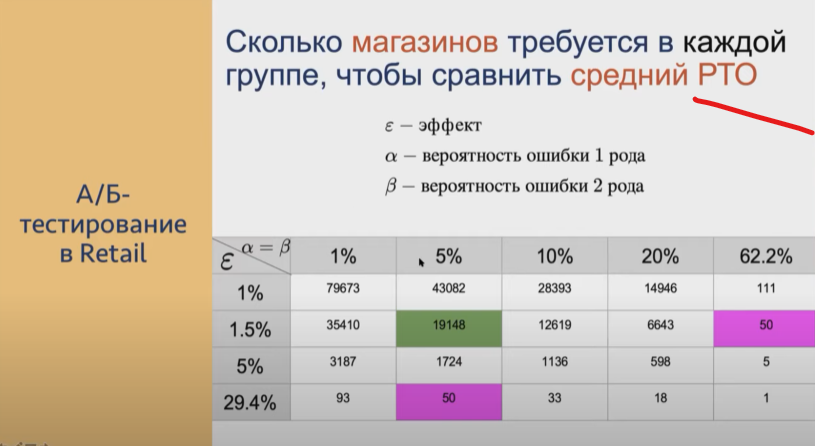